In [2]:
import pandas as pd

df = pd.read_csv("../data/processed/final_labeled_ward_data.csv")
features = [
    "population_density", "stop_density", "route_count", "route_density",
    "overlap_score", "border_overlap_score", "avg_fare"
]
X = df[features]
y = df["label"]


In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

le = LabelEncoder()
y_encoded = le.fit_transform(y)

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)



==== Random Forest ====

              precision    recall  f1-score   support

   cluttered       1.00      0.97      0.98        61
     optimal       0.50      1.00      0.67         5
 underserved       1.00      0.57      0.73         7

    accuracy                           0.93        73
   macro avg       0.83      0.85      0.79        73
weighted avg       0.97      0.93      0.94        73


Top 10 Feature Importances:
stop_density: 0.3761
route_count: 0.1790
route_density: 0.1447
population_density: 0.1272
avg_fare: 0.0947
overlap_score: 0.0767
border_overlap_score: 0.0016


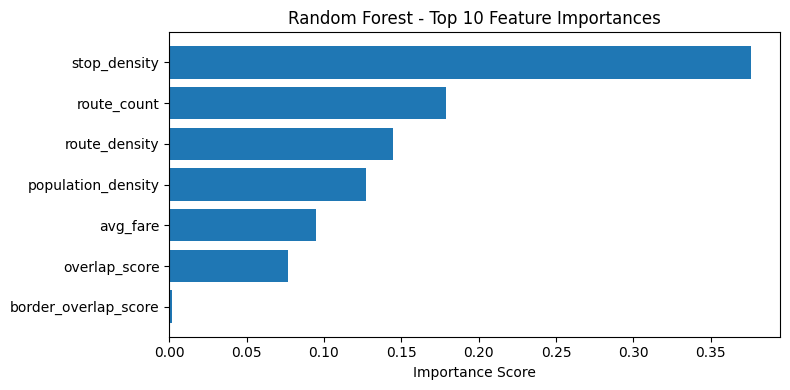


==== Logistic Regression ====

              precision    recall  f1-score   support

   cluttered       1.00      0.82      0.90        61
     optimal       0.31      0.80      0.44         5
 underserved       0.60      0.86      0.71         7

    accuracy                           0.82        73
   macro avg       0.64      0.83      0.68        73
weighted avg       0.91      0.82      0.85        73


Top 10 Coefficients (by magnitude):
stop_density: 5.3780
route_density: 1.8506
route_count: 1.8449
population_density: -0.6760
avg_fare: 0.3659
overlap_score: -0.2957
border_overlap_score: 0.2727

==== XGBoost ====

              precision    recall  f1-score   support

   cluttered       1.00      0.97      0.98        61
     optimal       0.62      1.00      0.77         5
 underserved       1.00      0.86      0.92         7

    accuracy                           0.96        73
   macro avg       0.88      0.94      0.89        73
weighted avg       0.97      0.96      0.96 

c:\Users\arshi\OneDrive\Desktop\FoodGapFinder\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:28:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


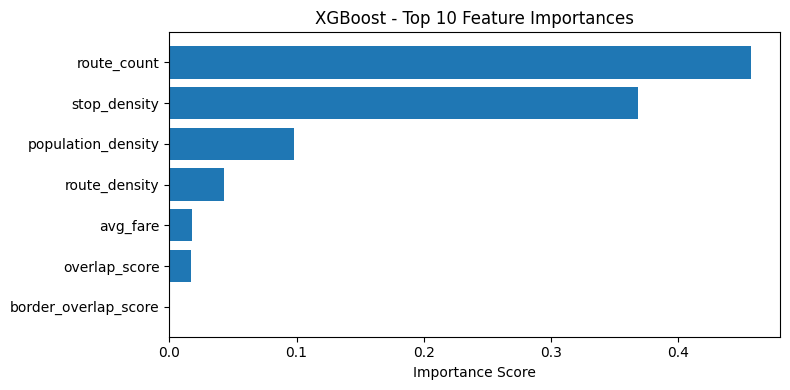

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    print(f"\n==== {name} ====\n")
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Feature importance
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names_sorted = [X.columns[i] for i in indices]

        print("\nTop 10 Feature Importances:")
        for i in range(min(10, len(importances))):
            print(f"{feature_names_sorted[i]}: {importances[indices[i]]:.4f}")

        # Optional: plot feature importances
        plt.figure(figsize=(8, 4))
        plt.barh(feature_names_sorted[:10][::-1], importances[indices[:10]][::-1])
        plt.title(f"{name} - Top 10 Feature Importances")
        plt.xlabel("Importance Score")
        plt.tight_layout()
        plt.show()

    elif hasattr(model, "coef_"):
        coef = model.coef_[0]
        indices = np.argsort(np.abs(coef))[::-1]
        feature_names_sorted = [X.columns[i] for i in indices]

        print("\nTop 10 Coefficients (by magnitude):")
        for i in range(min(10, len(coef))):
            print(f"{feature_names_sorted[i]}: {coef[indices[i]]:.4f}")


In [6]:
import joblib
import os

os.makedirs("../models", exist_ok=True)

joblib.dump(models["XGBoost"], "../models/xgboost_model.pkl")

joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(le, "../models/label_encoder.pkl")

print(" Model, Scaler, and LabelEncoder saved successfully.")


 Model, Scaler, and LabelEncoder saved successfully.
